In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('../../')
from matplotlib import pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from DataPreparation.Ingestion.Ingestion import read_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from DataPreparation.Preprocessing.Preprocessing import preprocess_data
from catboost import CatBoostRegressor


#### Ingestion

In [2]:
df = read_data(
    path='../../../DataFiles/house-prices-advanced-regression-techniques/')

In [3]:
x_train_p, y_train, x_val_p, y_val = preprocess_data(df)

# Print Nan values
print(x_train_p.isnull().sum())
print(x_train_p.shape)

columns having only 2 unique values: 3
['Street', 'Utilities', 'CentralAir']
columns having only <=10 unique values: 33
['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
columns having only <=10 unique values: 3
['Neighborhood', 'Exterior1st', 'Exterior2nd']
MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleType_New             0
SaleType_WD              0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 138, dtype: int64
(1095, 138)


#### Initiating the Model

In [4]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
cb_params = {"iterations": [200, 500],
             "learning_rate": [0.01, 0.1],
             "depth": [3, 6]}
cb_random = GridSearchCV(estimator=cb, param_grid=cb_params, n_jobs=-1)

cb_random.fit(x_train_p, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f300b564c10>,
             n_jobs=-1,
             param_grid={'depth': [3, 6], 'iterations': [200, 500],
                         'learning_rate': [0.01, 0.1]})

In [5]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [6]:
print(cb_random.best_params_)

cb_random_final = cb.set_params(
    **cb_random.best_params_, random_state=17).fit(x_train_p, y_train)


{'depth': 6, 'iterations': 500, 'learning_rate': 0.1}


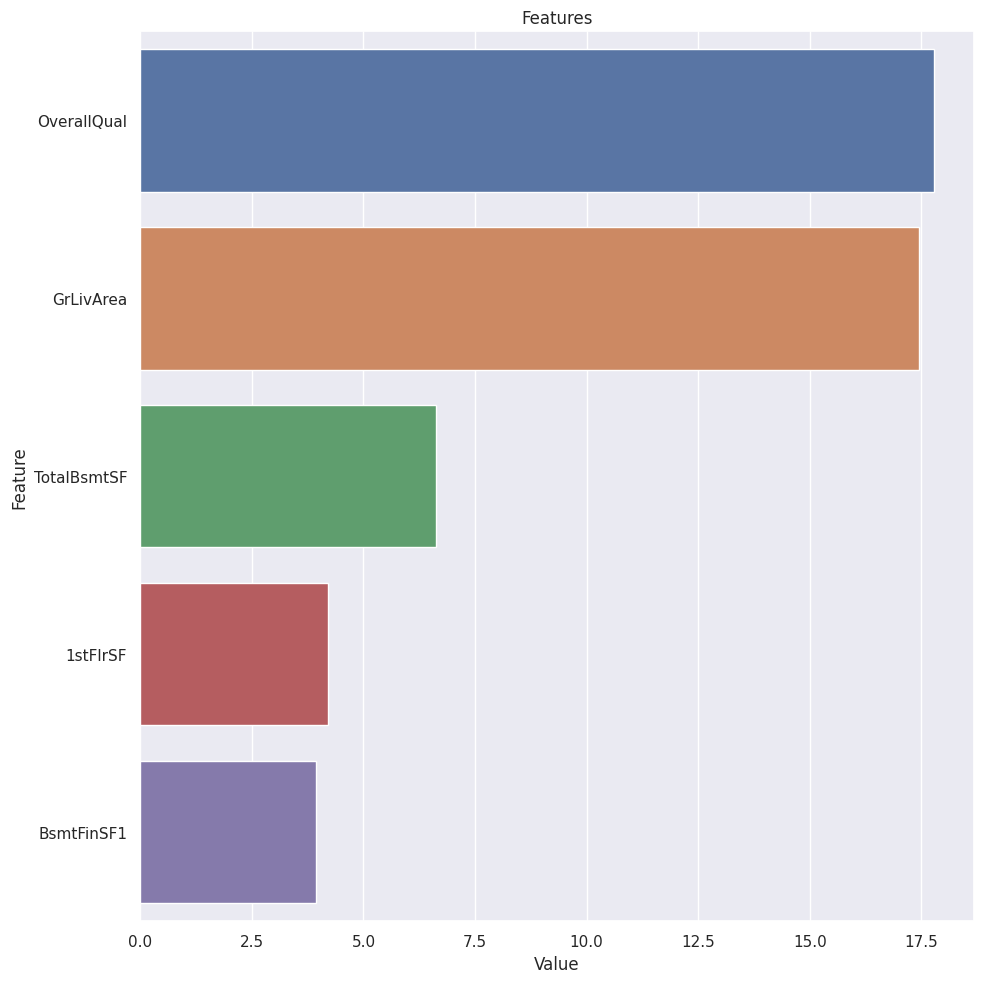

In [7]:
plot_importance(cb_random_final, x_train_p, num=5)

#### Validating the Model

In [9]:
preds_cb = cb_random_final.predict(x_val_p)
mae_cb = mean_absolute_error(y_val, preds_cb)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds_cb))

print(mae_cb)
print(rmse_cb)

15638.595913725061
23855.516144771584


#### Saving the Model